In [1]:
# import required packages
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

# import MAGI-X packages
from scripts.magix.dynamic import nnModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### Lorenz 96

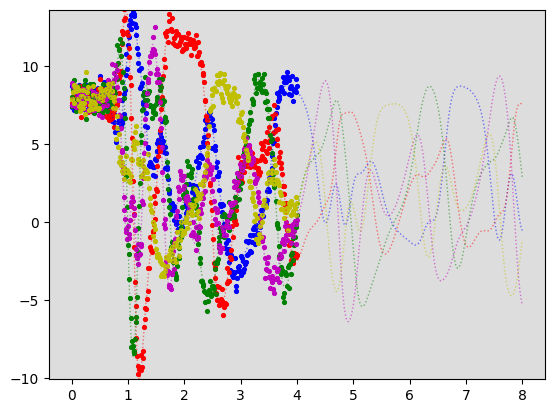

In [3]:
seed = 188714368 # random seed
example = 'lorenz96' # example
noise = [0.5] * 5 # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata),np.max(xdata))
plt.show()

In [4]:
# MAP
torch.manual_seed(seed)
# define neural network dynamic
magix_node = [no_comp,1024,no_comp]
fOde = nnModule(magix_node, dp=0.2) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=3000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

/home/chuang397/.venv/lib64/python3.8/site-packages/linear_operator/utils/sparse.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


1/3000 iteration: 40.964927
600/3000 iteration: 8.714046
1200/3000 iteration: 7.633694
1800/3000 iteration: 7.516353
2400/3000 iteration: 7.517418
3000/3000 iteration: 7.536967
run time: 190.77 seconds


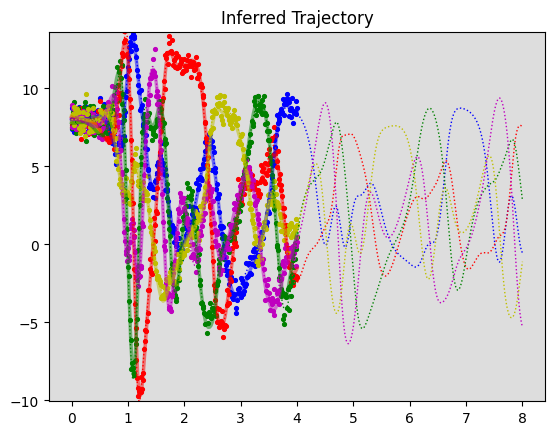

In [5]:
# inferred 
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata),np.max(xdata))
plt.title('Inferred Trajectory')
plt.show()

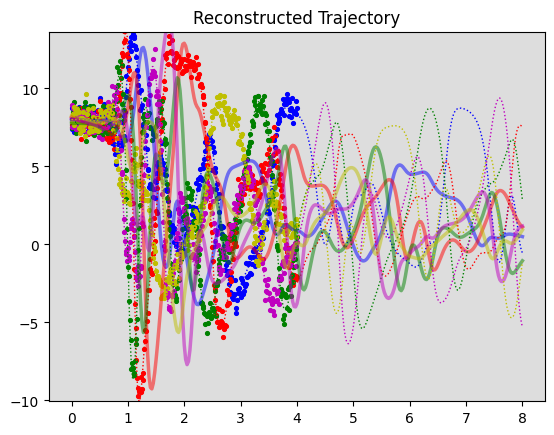

In [6]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata),np.max(xdata))
plt.title('Reconstructed Trajectory')
plt.show()